## <u>*Calssifications Modelling for area as a Target Feature*</u>

In [ ]:
%run C:\Users\Omar\Desktop\Omar_Files\Python_Analysis\Auto_Insurance\Notebooks\Data_Analysis\3_EDA.ipynb

In [13]:
df5=df.copy()
df5.drop(["clm"],axis=1,inplace=True)

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )


from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier,XGBRFClassifier
import warnings
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,BaggingClassifier
)

from hyperopt import fmin,tpe,STATUS_OK,Trials,hp
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
   

### *A.*<br> <u>*Models Preparation :*</u>

#### *A.1. <br> <u>Classification Models to use :*</u>

In [4]:
models = {
                "RandomForestClassifier": RandomForestClassifier(),
                "DecisionTreeClassifier": DecisionTreeClassifier(),
                "GradientBoostingClassifier": GradientBoostingClassifier(),
                "XGBClassifier": XGBClassifier(),
                "CatBoostClassifier": CatBoostClassifier(verbose=False),
                "AdaBoostClassifier": AdaBoostClassifier(),
                "BaggingClassifier":BaggingClassifier()
            }

#### *A.2. <br> <u>Classification Models spaces preperartion to use in hyperopt :*</u>

In [5]:
space_xgboost_clf  = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
}

space_rf_clf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    #'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    'bootstrap': hp.choice('bootstrap', [True, False]),
}


space_GradientBoosting_clf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
}

space_DT = {
    #'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': hp.choice('depth', range(1, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
}



space_Bagging_clf = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_samples': hp.uniform('max_samples', 0.1, 1.0),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'bootstrap_features': hp.choice('bootstrap_features', [True, False]),
}

space_catboost_clf = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'iterations': hp.quniform('iterations', 50, 200, 1),
    'depth': hp.choice('depth', range(1, 15)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.1, 10),
    'border_count': hp.choice('border_count', [32, 64, 128, 256]),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1),
}

---

### *B. <br> <u>Data preparation:*</u>

#### *B.1. <br> <u>Solving imbalanced issue if exist :*</u>

In [14]:
print(df5.groupby("area")["area"].count())
print(df5.groupby("area")["area"].count()/df5["area"].count())

area
A    16312
B    13341
C    20540
D     8173
E     5912
F     3578
Name: area, dtype: int64
area
A    0.240391
B    0.196608
C    0.302700
D    0.120446
E    0.087126
F    0.052729
Name: area, dtype: float64


> *The data balnance between between areas  are varies and we need to apply SMOTE method from imblearn.over_sampling*

#### *B.2. <br> <u>LabelEncoding for categorical features :*</u>

In [15]:
LabelEncoder_cat = LabelEncoder()
for col in df5:
    if col in ["numclaims","veh_body","veh_age","gender","area","agecat"]:
        df5[col]=LabelEncoder_cat.fit_transform(df5[col])

#### *B.3. <br> <u>Define x & y features :*</u>

In [16]:
x=df5.drop("area",axis=1)
y=df5["area"]

#### *B.4. <br> <u>apply data balance method :*</u>

In [17]:
from imblearn.over_sampling import SMOTE
smk=SMOTE(random_state=41)
x,y=smk.fit_resample(x,y)

#### *B.5. <br> <u>data splitting (training & testing) :*</u>

In [19]:
xtrain,xtest, ytrain, ytest = train_test_split(x, y, train_size=0.7, test_size=0.3,random_state=41)

---

### *C. <br> <u>Modelling:*</u>

* *Note : Data scalling is not required as we are applying Tree -based models*

#### *C.1 <br> <u>* *XGBClassifier:*</u>

In [20]:
def model_XGBClassifier(space_xgboost_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("XGBClassifier",XGBClassifier( 
               learning_rate=float(space_xgboost_clf['learning_rate']),
               n_estimators=int(space_xgboost_clf['n_estimators']),
               max_depth=int(space_xgboost_clf['max_depth']),
               min_child_weight=int(space_xgboost_clf['min_child_weight']),
               subsample=float(space_xgboost_clf["subsample"]),
               gamma=float(space_xgboost_clf['gamma']),
               colsample_bytree=float(space_xgboost_clf['colsample_bytree'])                                      

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [21]:
def model_XGBClassifier_best(best_model_XGBClassifier):
    y_model_XGBClassifier_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
           #('preprocessor', preprocessor),
            ("XGBClassifier",XGBClassifier( 
               learning_rate=float(best_model_XGBClassifier['learning_rate']),
               n_estimators=int(best_model_XGBClassifier['n_estimators']),
               max_depth=int(best_model_XGBClassifier['max_depth']),
               min_child_weight=int(best_model_XGBClassifier['min_child_weight']),
               subsample=float(best_model_XGBClassifier["subsample"]),
               gamma=float(best_model_XGBClassifier['gamma']),
               colsample_bytree=float(best_model_XGBClassifier['colsample_bytree'])                                      

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_model_XGBClassifier_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_XGBClassifier_best Accuracy_result:',  np.mean(Accuracy_list))

In [22]:
best_model_XGBClassifier = fmin(fn=model_XGBClassifier, space=space_xgboost_clf, algo=tpe.suggest, max_evals=10)

100%|██████████| 10/10 [09:01<00:00, 54.16s/trial, best loss: 0.2818078545926647] 


In [23]:
model_XGBClassifier_best(best_model_XGBClassifier)

model_XGBClassifier_best Accuracy_result: 0.2538407443470735


---

#### *C.2 <br> <u>* *RandomForestClassifier:*</u>

In [24]:
def model_rf_clf(space_rf_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("RandomForestClassifier",RandomForestClassifier(              
                                    n_estimators=int(space_rf_clf['n_estimators']),
                                    #criterion=int(space_rf_clf['criterion']),                                                       
                                    max_depth=int(space_rf_clf['max_depth']),
                                    min_samples_split=float(space_rf_clf['min_samples_split']),
                                    min_samples_leaf=float(space_rf_clf['min_samples_leaf']),
                                    #max_features=float(space_rf_clf["max_features"]),
                                    bootstrap=int(space_rf_clf['bootstrap'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [25]:
def model_rf_clf_best(best_model_rf_clf):
    y_model_rf_clf_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
              ("RandomForestClassifier",RandomForestClassifier(              
                                    n_estimators=int(best_model_rf_clf['n_estimators']),
                                    #criterion=int(best_model_rf_clf['criterion']),                                                       
                                    max_depth=int(best_model_rf_clf['max_depth']),
                                    min_samples_split=float(best_model_rf_clf['min_samples_split']),
                                    min_samples_leaf=float(best_model_rf_clf['min_samples_leaf']),
                                    #max_features=float(space_rf_clf["max_features"]),
                                    bootstrap=int(best_model_rf_clf['bootstrap'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_model_rf_clf_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_rf_clf_best Accuracy_result:',  np.mean(Accuracy_list))

In [26]:
best_model_rf_clf = fmin(fn=model_rf_clf, space=space_rf_clf, algo=tpe.suggest, max_evals=10)
model_rf_clf_best(best_model_rf_clf)

100%|██████████| 10/10 [00:30<00:00,  3.01s/trial, best loss: 0.16528724440116846]
model_rf_clf_best Accuracy_result: 0.25213675213675213


---

#### *C.3 <br> <u>* *GradientBoostingClassifier:*</u>

In [27]:
def model_GradientBoosting_clf(space_GradientBoosting_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("GradientBoostingClassifier",GradientBoostingClassifier(              
                                    n_estimators=int(space_GradientBoosting_clf['n_estimators']),                                                       
                                    learning_rate=float(space_GradientBoosting_clf['learning_rate']),
                                    max_depth=int(space_GradientBoosting_clf['max_depth']),
                                    min_samples_split=float(space_GradientBoosting_clf['min_samples_split']),
                                    min_samples_leaf=float(space_GradientBoosting_clf['min_samples_leaf']),
                                    subsample=float(space_GradientBoosting_clf['subsample'])

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [28]:
def model_GradientBoosting_clf_best(best_model_GradientBoosting_clf):
    y_DT_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("GradientBoostingClassifier",GradientBoostingClassifier(              
                                    n_estimators=int(best_model_GradientBoosting_clf['n_estimators']),                                                       
                                    learning_rate=float(best_model_GradientBoosting_clf['learning_rate']),
                                    max_depth=int(best_model_GradientBoosting_clf['max_depth']),
                                    min_samples_split=float(best_model_GradientBoosting_clf['min_samples_split']),
                                    min_samples_leaf=float(best_model_GradientBoosting_clf['min_samples_leaf']),
                                    subsample=float(best_model_GradientBoosting_clf['subsample'])


                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_DT_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_GradientBoosting_clf_best Accuracy_result:',  np.mean(Accuracy_list))

In [29]:
best_model_GradientBoosting_clf = fmin(fn=model_GradientBoosting_clf, space=space_GradientBoosting_clf, algo=tpe.suggest, max_evals=10)
model_GradientBoosting_clf_best(best_model_GradientBoosting_clf)

100%|██████████| 10/10 [06:20<00:00, 38.03s/trial, best loss: 0.16528724440116846]
model_GradientBoosting_clf_best Accuracy_result: 0.16528724440116846


----

#### *C.4 <br> <u>* *DecisionTreeClassifier:*</u>

In [30]:
def model_DT(space_DT):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",DecisionTreeClassifier(              
                                    #criterion=int(space_DT['criterion']),                                                       
                                    splitter=str(space_DT['splitter']),
                                    max_depth=int(space_DT['max_depth']),
                                    min_samples_split=float(space_DT['min_samples_split']),
                                    min_samples_leaf=float(space_DT['min_samples_leaf']),
                                    #max_features=int(space_DT['max_features'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 


In [31]:
def model_DT_best(best_model_DT):
    y_DT_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",DecisionTreeClassifier(              
                                    #criterion=int(best_model_DT['criterion']),                                                       
                                    #splitter=str(best_model_DT['splitter']),
                                    max_depth=int(best_model_DT['depth']),
                                    min_samples_split=float(best_model_DT['min_samples_split']),
                                    min_samples_leaf=float(best_model_DT['min_samples_leaf']),
                                    #max_features=int(best_model_DT['max_features'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_DT_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_DT_best Accuracy_result:',  np.mean(Accuracy_list))

In [32]:
best_model_DT = fmin(fn=model_DT, space=space_DT, algo=tpe.suggest, max_evals=10)
model_DT_best(best_model_DT)

100%|██████████| 10/10 [00:00<00:00, 24.10trial/s, best loss: 0.17169750081142487]
model_DT_best Accuracy_result: 0.22192469977280105


---

#### *C.5 <br> <u>* *BaggingClassifier:*</u>

In [33]:
def model_Bagging(space_Bagging_clf):
    base_classifier =DecisionTreeClassifier()
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",BaggingClassifier(base_estimator=base_classifier,                
                                    n_estimators=int(space_Bagging_clf['n_estimators']),
                                    bootstrap=int(space_Bagging_clf["bootstrap"]),                                                       
                                    bootstrap_features=int(space_Bagging_clf['bootstrap_features']),
                                    max_samples=float(space_Bagging_clf["max_samples"]),
                                    max_features=float(space_Bagging_clf["max_features"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [34]:
def model_Bagging_best(best_model_BaggingClassifier):
    base_classifier =DecisionTreeClassifier()
    y_Bagging_best=[]
    Accuracy_list=[]

    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",BaggingClassifier(base_estimator=base_classifier,                
                                    n_estimators=int(best_model_BaggingClassifier['n_estimators']),
                                    bootstrap=int(best_model_BaggingClassifier["bootstrap"]),                                                       
                                    bootstrap_features=int(best_model_BaggingClassifier['bootstrap_features']),
                                    max_samples=float(best_model_BaggingClassifier["max_samples"]),
                                    max_features=float(best_model_BaggingClassifier["max_features"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_Bagging_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_Bagging_best Accuracy_result:',  np.mean(Accuracy_list))

In [35]:
best_model_BaggingClassifier=fmin(fn=model_Bagging, space=space_Bagging_clf, algo=tpe.suggest, max_evals=10)
model_Bagging_best(best_model_BaggingClassifier)

100%|██████████| 10/10 [04:21<00:00, 26.12s/trial, best loss: 0.29795520934761444]
model_Bagging_best Accuracy_result: 0.2913556204695445


---

#### *C.6 <br> <u>* *CatBoostClassifier:*</u>

In [36]:
def model_catboost(space_catboost_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostClassifier(
                                    learning_rate=float(space_catboost_clf['learning_rate']),
                                    depth=int(space_catboost_clf["depth"]),                                                       
                                    iterations=int(space_catboost_clf['iterations']),
                                    l2_leaf_reg=float(space_catboost_clf["l2_leaf_reg"]),
                                    border_count=int(space_catboost_clf["border_count"]),
                                    bagging_temperature=float(space_catboost_clf["bagging_temperature"]),
                                    random_strength=float(space_catboost_clf["random_strength"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [37]:
def model_catboost_best(best_model_catboost):
    y_CatBoostClassifier_best=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostClassifier(
                                    learning_rate=float(best_model_catboost['learning_rate']),
                                    depth=int(best_model_catboost["depth"]),                                                       
                                    iterations=int(best_model_catboost['iterations']),
                                    l2_leaf_reg=float(best_model_catboost["l2_leaf_reg"]),
                                    border_count=int(best_model_catboost["border_count"]),
                                    bagging_temperature=float(best_model_catboost["bagging_temperature"]),
                                    random_strength=float(best_model_catboost["random_strength"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_CatBoostClassifier_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    print('model_catboost_best Accuracy_result:', Accuracy_result)


In [38]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost_clf, algo=tpe.suggest, max_evals=10)
model_catboost_best(best_model_catboost)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]0:	learn: 1.7837704	total: 853ms	remaining: 2m 24s
1:	learn: 1.7765355	total: 1.61s	remaining: 2m 15s
2:	learn: 1.7694198	total: 2.32s	remaining: 2m 9s
3:	learn: 1.7627530	total: 3.04s	remaining: 2m 7s
4:	learn: 1.7563562	total: 3.76s	remaining: 2m 4s
5:	learn: 1.7504933	total: 4.51s	remaining: 2m 4s
6:	learn: 1.7449284	total: 5.24s	remaining: 2m 2s
7:	learn: 1.7393624	total: 5.95s	remaining: 2m 1s
8:	learn: 1.7342514	total: 6.91s	remaining: 2m 4s
9:	learn: 1.7293473	total: 8.09s	remaining: 2m 10s
10:	learn: 1.7246491	total: 9.27s	remaining: 2m 14s
11:	learn: 1.7203020	total: 10.1s	remaining: 2m 13s
12:	learn: 1.7161184	total: 10.8s	remaining: 2m 10s
13:	learn: 1.7120848	total: 11.5s	remaining: 2m 8s
14:	learn: 1.7083799	total: 12.1s	remaining: 2m 6s
15:	learn: 1.7047617	total: 12.8s	remaining: 2m 4s
16:	learn: 1.7012956	total: 13.7s	remaining: 2m 4s
17:	learn: 1.6977600	total: 14.9s	remaining: 2m 6s
18:	learn: 1.6943580	total: 16s	

---

### *D <br> <u>* *running Results:*</u>

### *D.1 <br> <u>* *best Results:*</u>

> *XGBClassifier has the highest accuracy score*

In [39]:
base_classifier =DecisionTreeClassifier()
y_model_XGBClassifier_best=[]
Accuracy_list=[]
model_opt = Pipeline(
        steps=[
           #('preprocessor', preprocessor),
            ("BaggingClassifier",BaggingClassifier(base_estimator=base_classifier,                
                                    n_estimators=int(best_model_BaggingClassifier['n_estimators']),
                                    bootstrap=int(best_model_BaggingClassifier["bootstrap"]),                                                       
                                    bootstrap_features=int(best_model_BaggingClassifier['bootstrap_features']),
                                    max_samples=float(best_model_BaggingClassifier["max_samples"]),
                                    max_features=float(best_model_BaggingClassifier["max_features"])
                                      

                                    ))

                                    ])
                                  
model_opt.fit(xtrain,ytrain)
Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
y_pred=model_opt.predict(xtest)
y_model_XGBClassifier_best.append(y_pred)

Accuracy_result=accuracy_score(ytest,y_pred)
Accuracy_list.append(Accuracy_result)
    

In [40]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.23      0.16      0.19      6123
           1       0.21      0.10      0.13      6135
           2       0.31      0.63      0.42      6111
           3       0.25      0.14      0.18      6147
           4       0.28      0.22      0.25      6148
           5       0.35      0.51      0.41      6308

    accuracy                           0.29     36972
   macro avg       0.27      0.29      0.26     36972
weighted avg       0.27      0.29      0.26     36972



In [41]:
unique_labels(ytest)
labels=unique_labels(ytest)
col_names=[f"predicted{label}"for label in labels ]
index_names=[f"Actual{label}"for label in labels ]
pd.DataFrame(confusion_matrix(ytest, y_pred),columns=col_names,index=index_names)

,predicted0,predicted1,predicted2,predicted3,predicted4,predicted5
Actual0,1006,424,2983,339,455,916
Actual1,912,601,2528,499,618,977
Actual2,1089,335,3826,90,116,655
Actual3,636,556,1401,878,1062,1614
Actual4,516,550,1019,856,1354,1853
Actual5,307,369,425,812,1205,3190


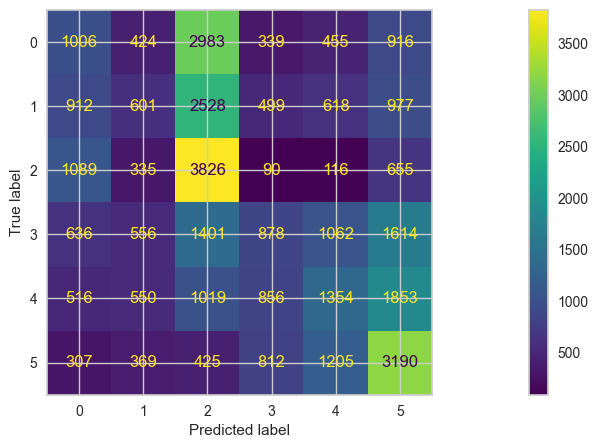

In [42]:
matplotlib.rcParams["figure.figsize"]=(25,5)
ConfusionMatrixDisplay(confusion_matrix(ytest,y_pred)).plot()

In [43]:
from sklearn.multiclass import OneVsRestClassifier

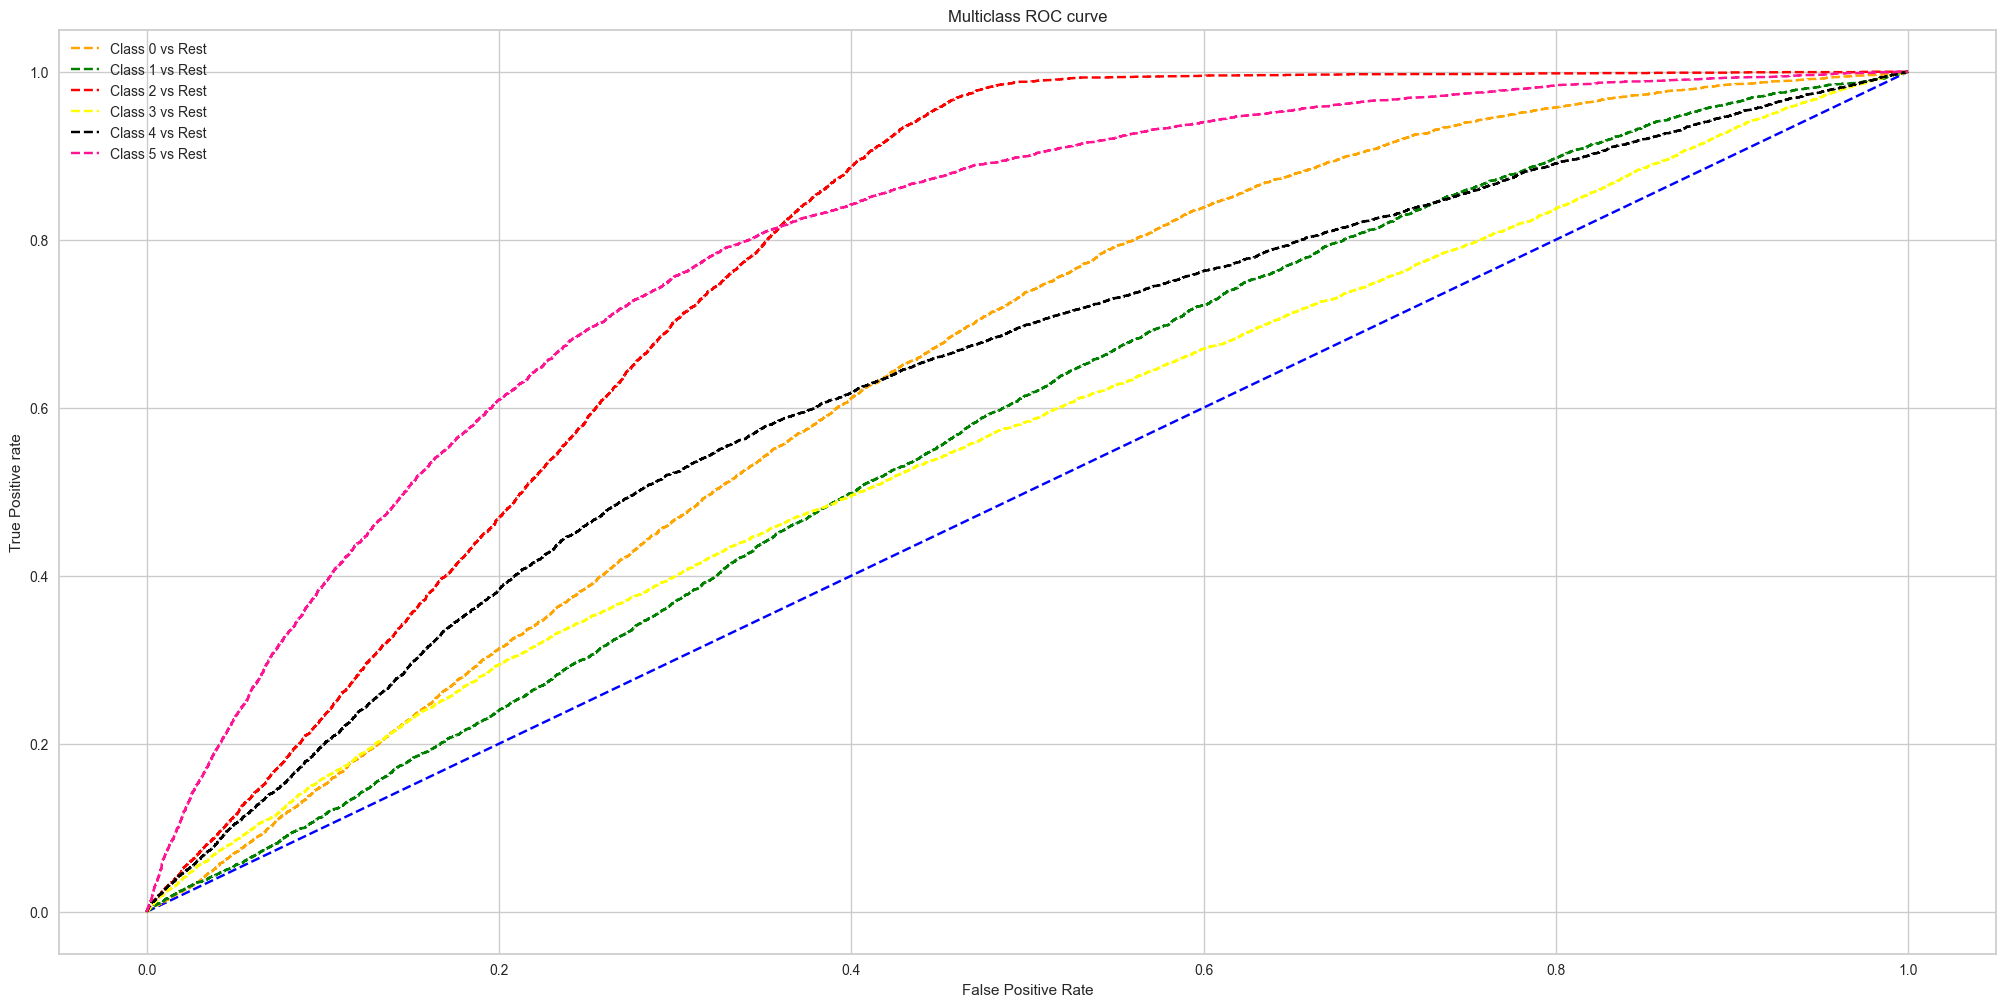

In [45]:
# fit model
matplotlib.rcParams["figure.figsize"]=(25,12)
clf = OneVsRestClassifier(BaggingClassifier(base_estimator=base_classifier,                
                                    n_estimators=int(best_model_BaggingClassifier['n_estimators']),
                                    bootstrap=int(best_model_BaggingClassifier["bootstrap"]),                                                       
                                    bootstrap_features=int(best_model_BaggingClassifier['bootstrap_features']),
                                    max_samples=float(best_model_BaggingClassifier["max_samples"]),
                                    max_features=float(best_model_BaggingClassifier["max_features"])))                            

clf.fit(xtrain, ytrain)
pred = clf.predict(xtest)
pred_prob = clf.predict_proba(xtest)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 6

random_probs = [0 for i in range(len(ytest))]
p_fpr, p_tpr, _ = roc_curve(ytest, random_probs, pos_label=1)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(ytest, pred_prob[:,i], pos_label=i)
    
# plotting    'C', 'A', 'E', 'D', 'B', 'F']
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class C vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class A vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class E vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class D vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class B vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='DeepPink', label='Class F vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('Multiclass ROC',dpi=300);    


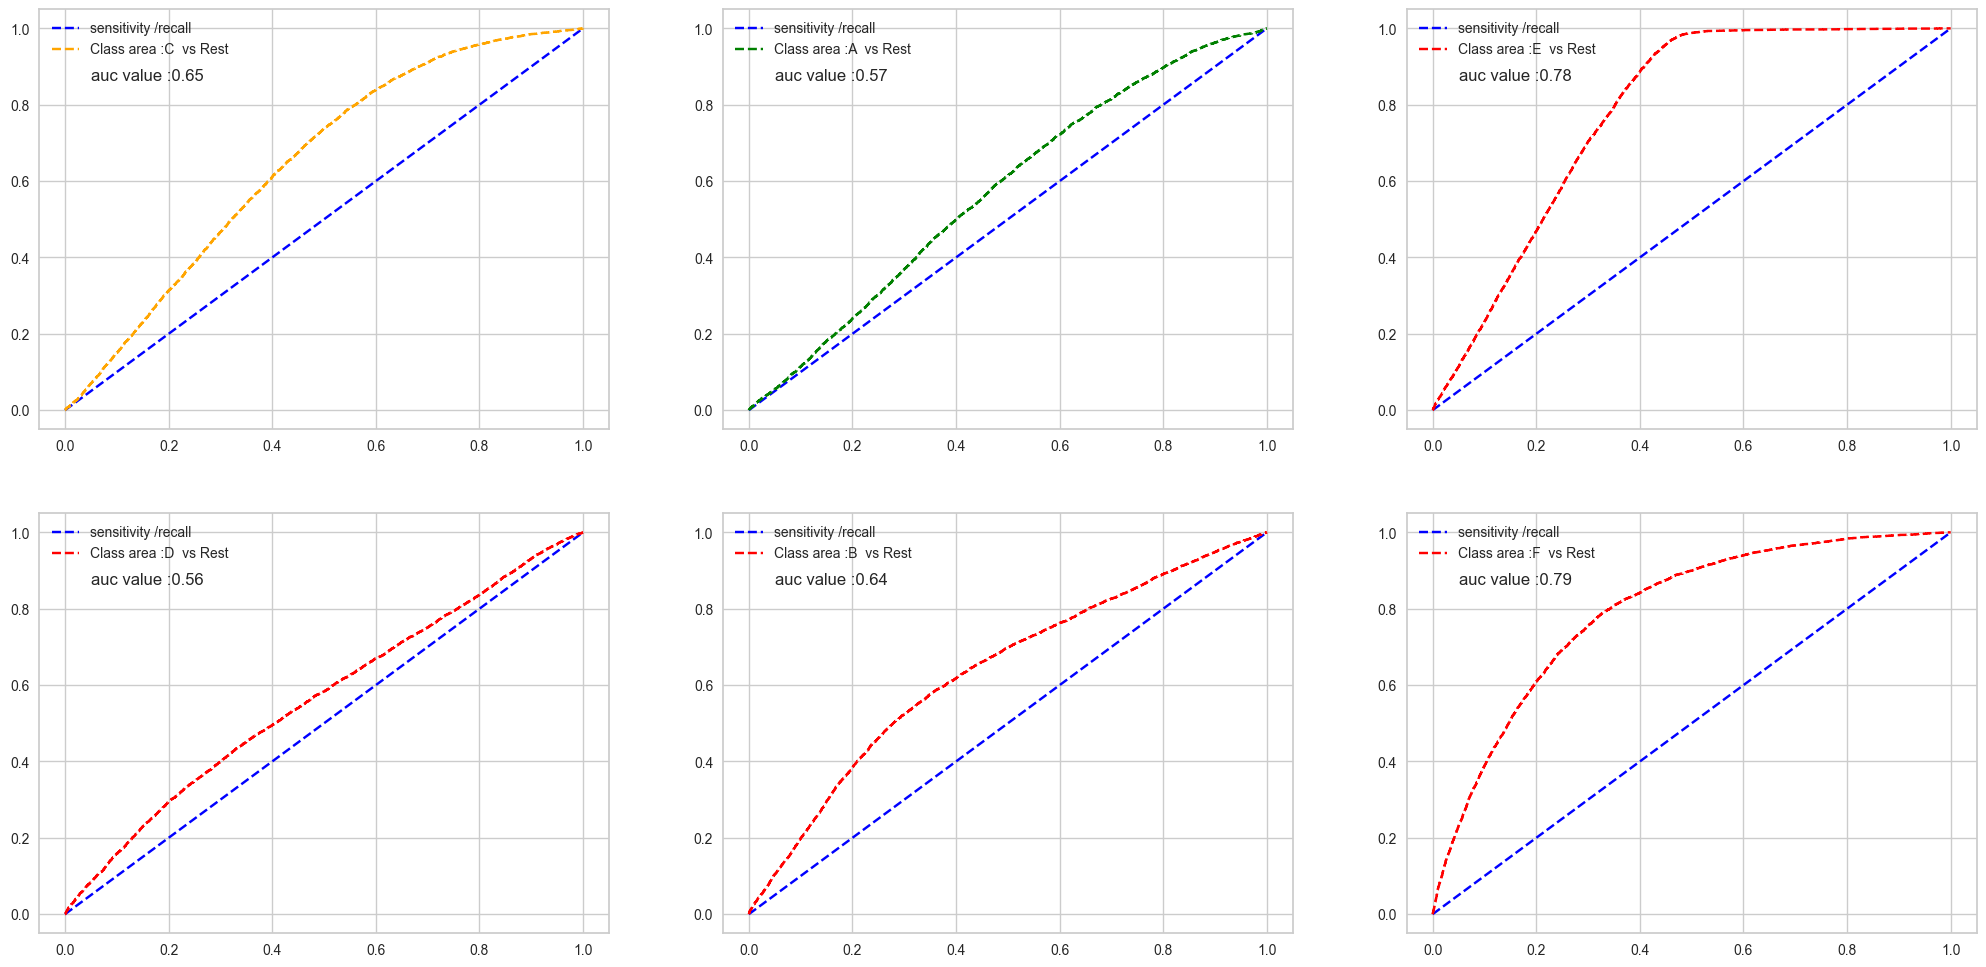

In [49]:
plt.subplot(231)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange')
plt.text(0.05,0.865, f'auc value :{round(auc(fpr[0], tpr[0]),2)}')
plt.legend(['sensitivity /recall','Class area :C  vs Rest'])

plt.subplot(232)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.05,0.865, f'auc value :{round(auc(fpr[1], tpr[1]),2)}')
plt.legend(['sensitivity /recall','Class area :A  vs Rest'])

plt.subplot(233)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red')
plt.text(0.05,0.865, f'auc value :{round(auc(fpr[2], tpr[2]),2)}')
plt.legend(['sensitivity /recall','Class area :E  vs Rest'])

plt.subplot(234)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red')
plt.text(0.05,0.865, f'auc value :{round(auc(fpr[3], tpr[3]),2)}')
plt.legend(['sensitivity /recall','Class area :D  vs Rest'])

plt.subplot(235)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red')
plt.text(0.05,0.865, f'auc value :{round(auc(fpr[4], tpr[4]),2)}')
plt.legend(['sensitivity /recall','Class area :B  vs Rest'])

plt.subplot(236)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[5], tpr[5], linestyle='--',color='red')
plt.text(0.05,0.865, f'auc value :{round(auc(fpr[5], tpr[5]),2)}')
plt.legend(['sensitivity /recall','Class area :F  vs Rest'])

In [50]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/area_prediction_model.pkl","wb") as f:
    pickle.dump(model_opt,f)

---